# Modelo Redes Neuronales

## 1. Preprocesamiento

Primero crearemos un dataset con la variable preprocesada y las variables exógenas que se incluirán.

### 1.1 Preprocesamiento variable Consumo (Y)

Total Nacional. Datos ajustados de estacionalidad y calendario. Gasto en consumo final de los hogares. Variación trimestral. Índices de volumen encadenados

https://ine.es/consul/serie.do?d=true&s=CNTR7162&c=2&

In [85]:
# Cell 1: Imports y carga de la serie de Consumo

import pandas as pd
import numpy as np

def periodo_a_fecha(periodo):
    año, trimestre = periodo.split('T')
    año = int(año); trimestre = int(trimestre)
    if trimestre == 1:
        return f"{año}-03-31"
    elif trimestre == 2:
        return f"{año}-06-30"
    elif trimestre == 3:
        return f"{año}-09-30"
    elif trimestre == 4:
        return f"{año}-12-31"

# Cargamos la serie principal de consumo
consumo = pd.read_csv('final/ch_trimestral2.csv', sep=';', decimal=',')
consumo['Fecha'] = consumo['PERIODO'].apply(periodo_a_fecha)
consumo['Fecha'] = pd.to_datetime(consumo['Fecha'])
consumo.set_index('Fecha', inplace=True)

# Renombramos y ajustamos frecuencia trimestral
df = consumo[['VALOR']].rename(columns={'VALOR': 'Consumo'}).astype(float)
df = df.asfreq('Q')


C:\Users\uax\AppData\Local\Temp\ipykernel_7828\2054776475.py:26: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.asfreq('Q')


### 1.2 Preprocesamiento variable exógena Tasa de ahorro (Nivel)

Dato base. Total Nacional. Tasa de ahorro. NC. Datos ajustados de estacionalidad y calendario. Hogares e Instituciones sin fines de lucro al servicio de los hogares.

https://ine.es/consul/serie.do?d=true&s=219-6925&nult=15

In [86]:
# Cell 2: Carga de la variable exógena Ahorro_nivel

# Tasa de ahorro
ahorro = pd.read_csv('final/ahorro.csv', sep=';', decimal=',')
ahorro['Fecha'] = ahorro['PERIODO'].apply(periodo_a_fecha)
ahorro['Fecha'] = pd.to_datetime(ahorro['Fecha'])
ahorro.set_index('Fecha', inplace=True)
ahorro = ahorro[['VALOR']].rename(columns={'VALOR': 'Ahorro_nivel'}).astype(float)
ahorro = ahorro.asfreq('Q')


C:\Users\uax\AppData\Local\Temp\ipykernel_7828\1621867197.py:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ahorro = ahorro.asfreq('Q')


### 1.3 Variables exógenas y df final

In [87]:
# Cell 3: Creación de dummies de crisis y unión de Consumo + Ahorro

# Empezamos uniendo Consumo y Ahorro
df2 = df.join(ahorro['Ahorro_nivel'], how='left')

# Dummies de crisis financieras y COVID
df2['dummy_crisis_2008'] = ((df2.index >= '2008-07-01') & (df2.index <= '2010-03-31')).astype(int)
df2['dummy_crisis_2012'] = ((df2.index >= '2012-01-01') & (df2.index <= '2013-06-30')).astype(int)
df2['dummy_covid']      = ((df2.index >= '2020-01-01') & (df2.index <= '2020-12-31')).astype(int)

# Eliminar posibles NaN resultantes (p. ej. primeros trimestres de Ahorro)
df2 = df2.dropna()


### 1.4 División train y test

In [88]:
# Cell 4: División en entrenamiento y prueba (sin PIB_lag1)

train_end = '2020-12-31'
df_train = df2.loc[:train_end].copy()
df_test  = df2.loc[train_end:].copy()

y_train = df_train['Consumo']
y_test  = df_test['Consumo']

exog_vars = ['Ahorro_nivel', 'dummy_crisis_2008', 'dummy_crisis_2012', 'dummy_covid']
X_train = df_train[exog_vars]
X_test  = df_test[exog_vars]

print(f'Tamaño train: {len(y_train)}, Tamaño test: {len(y_test)}')


Tamaño train: 88, Tamaño test: 14


In [89]:
df2.head()

,Consumo,Ahorro_nivel,dummy_crisis_2008,dummy_crisis_2012,dummy_covid
Fecha,,,,,
1999-03-31,-1.5225,9.9,0,0,0
1999-06-30,1.8978,9.5,0,0,0
1999-09-30,1.3801,9.3,0,0,0
1999-12-31,1.9357,9.7,0,0,0
2000-03-31,1.3329,9.5,0,0,0


## 2. Análisis exploratorio

### 2.1 Escalado de variables

In [90]:
# Cell 5: Escalado de características y variable objetivo

from sklearn.preprocessing import MinMaxScaler

# 1) Escalar exógenas X_train y X_test en [0,1]
scaler_X = MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler_X.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler_X.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

# 2) Escalar la serie objetivo y_train y y_test en [0,1]
scaler_y = MinMaxScaler()
y_train_scaled = pd.Series(
    scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten(),
    index=y_train.index,
    name='Consumo'
)
y_test_scaled = pd.Series(
    scaler_y.transform(y_test.values.reshape(-1, 1)).flatten(),
    index=y_test.index,
    name='Consumo'
)

# Verificación rápida
print("Rango X_train_scaled:\n", X_train_scaled.min(), X_train_scaled.max(), "\n")
print("Rango y_train_scaled:\n", y_train_scaled.min(), y_train_scaled.max())


Rango X_train_scaled:
 Ahorro_nivel         0.0
dummy_crisis_2008    0.0
dummy_crisis_2012    0.0
dummy_covid          0.0
dtype: float64 Ahorro_nivel         1.0
dummy_crisis_2008    1.0
dummy_crisis_2012    1.0
dummy_covid          1.0
dtype: float64 

Rango y_train_scaled:
 0.0 0.9999999999999999


Los escaladores han funcionado correctamente: todas las variables exógenas están ahora en el rango [0,1] y tu serie objetivo también (0 a 1). Con esto, podemos pasar a preparar las secuencias para la RNN.

### 2.2 Creación de secuencias

In [91]:
# Cell 6: Creación de secuencias deslizantes para RNN/LSTM/GRU

import numpy as np

# 1) Definir el tamaño de ventana (número de pasos pasados que usaremos)
window_size = 8  # por ejemplo, 8 trimestres

# 2) Función para generar X_seq (3D) e y_seq (1D)
def create_sequences(X_df, y_series, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X_df)):
        Xs.append(X_df.iloc[i-window_size:i].values)
        ys.append(y_series.iloc[i])
    return np.array(Xs), np.array(ys)

# 3) Generar secuencias para entrenamiento y prueba
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window_size)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  window_size)

# 4) Verificar las dimensiones resultantes
print("X_train_seq.shape =", X_train_seq.shape)  # (n_muestras_train, window_size, n_features)
print("y_train_seq.shape =", y_train_seq.shape)  # (n_muestras_train,)
print("X_test_seq.shape  =", X_test_seq.shape)
print("y_test_seq.shape  =", y_test_seq.shape)


X_train_seq.shape = (80, 8, 4)
y_train_seq.shape = (80,)
X_test_seq.shape  = (6, 8, 4)
y_test_seq.shape  = (6,)


Los shapes son los esperados:

80 muestras de entrenamiento (88 - window_size = 80),

6 muestras de prueba (14 - window_size = 6),
todas con ventanas de tamaño 8 y 4 características. Perfecto.

## 3. Modelos

### 3.1 Definición de las arquitecturas principales

In [92]:
import torch
import torch.nn as nn

# Cell 7 (PyTorch): Definición de fábricas de modelos RNN, LSTM y GRU

# Número de variables de entrada (features) y longitud de ventana
n_features = X_train_seq.shape[2]
window_size = X_train_seq.shape[1]

class SimpleRNNModel(nn.Module):
    def __init__(self, units=32, dropout=0.2):
        super().__init__()
        self.rnn = nn.RNN(input_size=n_features, hidden_size=units,
                          nonlinearity='tanh', batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(units, 1)
    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.rnn(x)              # out: [batch, seq_len, units]
        h_last = out[:, -1, :]            # última salida de la secuencia
        h_last = self.dropout(h_last)
        return self.fc(h_last)            # [batch, 1]

class LSTMModel(nn.Module):
    def __init__(self, units=32, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=units,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(units, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        h_last = out[:, -1, :]
        h_last = self.dropout(h_last)
        return self.fc(h_last)

class GRUModel(nn.Module):
    def __init__(self, units=32, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(input_size=n_features, hidden_size=units,
                          batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(units, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        h_last = out[:, -1, :]
        h_last = self.dropout(h_last)
        return self.fc(h_last)

def build_simple_rnn(units=32, dropout=0.2, lr=1e-3):
    model = SimpleRNNModel(units, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    return model, optimizer, criterion

def build_lstm(units=32, dropout=0.2, lr=1e-3):
    model = LSTMModel(units, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    return model, optimizer, criterion

def build_gru(units=32, dropout=0.2, lr=1e-3):
    model = GRUModel(units, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    return model, optimizer, criterion

# Comprobación: instanciar un modelo y ver su arquitectura
model, optimizer, criterion = build_lstm()
print(model)



LSTMModel(
  (lstm): LSTM(4, 32, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## 4. Iteración de Hiperparámetros

Las celdas 8 y 9 de esta sección se ejecutaron más de una vez para poder conseguir mayor número de combinaciones

### 4.1 Selección aleatoria de los hiperparámetros

In [94]:
# Cell 8: Muestreo de 50 configuraciones nuevas evitando repetir y con espacio ampliado

import itertools, random, pandas as pd, os

# Definir espacio de búsqueda ampliado
param_grid = {
    'model_type':        ['rnn','lstm','gru'],
    'n_layers':          [1,2,3],
    'units':             [16,32,64,128],
    'dropout':           [0.0,0.1,0.2,0.3,0.5],
    'recurrent_dropout': [0.0,0.1,0.2],
    'activation':        ['tanh','relu'],
    'kernel_regularizer':[0.0,1e-4,1e-3],
    'bidirectional':     [False,True],
    'optimizer':         ['adam','rmsprop','sgd'],
    'lr':                [1e-3,5e-4,1e-4],
    'batch_size':        [16,32,64],
    'epochs':            [50,100,200],
    'window_size':       [4,8,12],
    'patience':          [5,10,20]
}

# Generar todas las combinaciones
all_combos = list(itertools.product(*param_grid.values()))
all_df = pd.DataFrame(all_combos, columns=param_grid.keys())

# Cargar combos ya procesadas
results_file = 'results/nn_hyperparam_results.csv'
if os.path.exists(results_file):
    done = pd.read_csv(results_file)[list(param_grid.keys())].drop_duplicates()
else:
    done = pd.DataFrame(columns=all_df.columns)

# Filtrar las pendientes
remaining = all_df.merge(done, on=list(param_grid.keys()), how='left', indicator=True)
remaining = remaining[remaining['_merge']=='left_only'].drop(columns=['_merge'])

# Tomar 50 al azar
random.seed(42)
to_run = remaining.sample(frac=1).head(500).reset_index(drop=True)

print(f"Preparadas {len(to_run)} configuraciones nuevas.")
to_run.head()


Preparadas 500 configuraciones nuevas.


,model_type,n_layers,units,dropout,recurrent_dropout,activation,kernel_regularizer,bidirectional,optimizer,lr,batch_size,epochs,window_size,patience
0,gru,2,128,0.0,0.2,relu,0.001,False,rmsprop,0.0010,32,100,12,10
1,rnn,3,16,0.5,0.0,tanh,0.000,True,sgd,0.0001,16,50,12,20
2,gru,2,16,0.5,0.0,relu,0.000,True,rmsprop,0.0001,64,200,4,5
3,gru,1,16,0.1,0.0,tanh,0.000,False,sgd,0.0005,64,50,8,10
4,gru,1,64,0.1,0.2,relu,0.001,False,sgd,0.0001,16,200,8,20


### 4.2 Entrenamiento cruzado con validación temporal y early stopping

In [95]:
# Cell 9: Loop de entrenamiento con PyTorch (5 folds + EarlyStopping)

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# Parámetros comunes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tscv = TimeSeriesSplit(n_splits=5)

# Cargar o inicializar resultados
results_file = 'results/nn_hyperparam_results.csv'
if os.path.exists(results_file):
    results = pd.read_csv(results_file).to_dict('records')
else:
    results = []

# Iterar sobre las combinaciones seleccionadas en Cell 8 (to_run)
for idx, combo in to_run.iterrows():
    # Extraer valores de combo
    mt    = combo.model_type
    nl    = combo.n_layers
    unts  = combo.units
    do    = combo.dropout
    rdo   = combo.recurrent_dropout
    act   = combo.activation
    kr    = combo.kernel_regularizer
    bi    = combo.bidirectional
    optn  = combo.optimizer
    lr    = combo.lr
    bs    = combo.batch_size
    ep    = combo.epochs
    ws    = combo.window_size
    pat   = combo.patience

    # (Re)generar secuencias si cambia window_size
    if ws != X_train_seq.shape[1]:
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, ws)
        X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  ws)

    # Convertir arrays a tensores
    X_full = torch.tensor(X_train_seq, dtype=torch.float32, device=device)
    y_full = torch.tensor(y_train_seq, dtype=torch.float32, device=device).unsqueeze(-1)

    fold_n = 1
    for tr_idx, vl_idx in tscv.split(X_full):
        # Particionar en entrenamiento y validación
        X_tr, X_vl = X_full[tr_idx], X_full[vl_idx]
        y_tr, y_vl = y_full[tr_idx], y_full[vl_idx]

        # Preparar DataLoader
        train_ds = TensorDataset(X_tr, y_tr)
        train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)

        # Construir modelo y enviar a device
        if mt=='rnn':
            model, optim, crit = build_simple_rnn(unts, do, lr)
        elif mt=='lstm':
            model, optim, crit = build_lstm(unts, do, lr)
        else:
            model, optim, crit = build_gru(unts, do, lr)
        model.to(device)

        # EarlyStopping manual
        best_loss = np.inf
        wait = 0

        for epoch in range(ep):
            model.train()
            for xb, yb in train_dl:
                optim.zero_grad()
                out = model(xb)
                loss = crit(out, yb)
                loss.backward()
                optim.step()

            # Validación
            model.eval()
            with torch.no_grad():
                pred_vl = model(X_vl)
                val_loss = crit(pred_vl, y_vl).item()

            if val_loss < best_loss:
                best_loss = val_loss
                best_state = model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= pat:
                    break

        # Restaurar mejor modelo y predecir
        model.load_state_dict(best_state)
        model.eval()
        with torch.no_grad():
            y_pred = model(X_vl).cpu().numpy()
        y_true = y_vl.cpu().numpy()

        # Desescalar
        y_pred_inv = scaler_y.inverse_transform(y_pred).flatten()
        y_true_inv = scaler_y.inverse_transform(y_true).flatten()

        # Métricas
        rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
        mae  = mean_absolute_error(y_true_inv, y_pred_inv)

        # Guardar resultado
        results.append({
            **combo.to_dict(),
            'fold': fold_n,
            'rmse': rmse,
            'mae': mae
        })
        print(f"Combo {idx+1}/{len(to_run)}, Fold {fold_n}: RMSE={rmse:.4f}, MAE={mae:.4f}")
        fold_n += 1

    # Actualizar CSV
    pd.DataFrame(results).to_csv(results_file, index=False)


Combo 1/500, Fold 1: RMSE=1.4521, MAE=1.3577
Combo 1/500, Fold 2: RMSE=1.7505, MAE=1.5121
Combo 1/500, Fold 3: RMSE=1.2192, MAE=0.9859
Combo 1/500, Fold 4: RMSE=0.5772, MAE=0.4977
Combo 1/500, Fold 5: RMSE=8.7871, MAE=4.7187
Combo 2/500, Fold 1: RMSE=24.5251, MAE=24.5069
Combo 2/500, Fold 2: RMSE=14.2105, MAE=14.1633
Combo 2/500, Fold 3: RMSE=17.0940, MAE=17.0087
Combo 2/500, Fold 4: RMSE=17.8851, MAE=17.8833
Combo 2/500, Fold 5: RMSE=10.6236, MAE=8.4450
Combo 3/500, Fold 1: RMSE=13.7434, MAE=13.7394
Combo 3/500, Fold 2: RMSE=19.4903, MAE=19.4418
Combo 3/500, Fold 3: RMSE=11.4173, MAE=11.3634
Combo 3/500, Fold 4: RMSE=23.3070, MAE=23.3038
Combo 3/500, Fold 5: RMSE=15.5800, MAE=14.6442
Combo 4/500, Fold 1: RMSE=15.1614, MAE=15.1582
Combo 4/500, Fold 2: RMSE=26.3595, MAE=26.3330
Combo 4/500, Fold 3: RMSE=21.2937, MAE=21.2517
Combo 4/500, Fold 4: RMSE=16.5772, MAE=16.5736
Combo 4/500, Fold 5: RMSE=8.9266, MAE=4.6305
Combo 5/500, Fold 1: RMSE=0.8985, MAE=0.7860
Combo 5/500, Fold 2: RMSE=3.

## 5. Selección de modelo final

### 5.1 Selección de Top 5

In [ ]:
# Cell 10: Selección de las Top-5 configuraciones por RMSE medio

import pandas as pd

# 1) Leer todos los resultados
results_df = pd.read_csv('results/nn_hyperparam_results.csv')

# 2) Definir las columnas de hiperparámetros
param_cols = [
    'model_type', 'n_layers', 'units', 'dropout', 'recurrent_dropout',
    'activation', 'kernel_regularizer', 'bidirectional', 'optimizer',
    'lr', 'batch_size', 'epochs', 'window_size', 'patience'
]

# 3) Agrupar por configuración y calcular media y desviación de RMSE y MAE
agg = results_df.groupby(param_cols).agg(
    rmse_mean = ('rmse', 'mean'),
    rmse_std  = ('rmse', 'std'),
    mae_mean  = ('mae', 'mean'),
    mae_std   = ('mae', 'std')
).reset_index()

# 4) Ordenar por RMSE medio ascendente
agg_sorted = agg.sort_values('rmse_mean')

# 5) Extraer Top-5
top5 = agg_sorted.head(5).reset_index(drop=True)

# 6) Mostrar y guardar
print("Top-5 configuraciones por menor RMSE medio:")
display(top5)

top5.to_csv('results/top5_hyperparams.csv', index=False)
print("Guardadas en 'top5_hyperparams.csv'")


Top-5 configuraciones por menor RMSE medio:


,model_type,n_layers,units,dropout,recurrent_dropout,activation,kernel_regularizer,bidirectional,optimizer,lr,batch_size,epochs,window_size,patience,rmse_mean,rmse_std,mae_mean,mae_std
0,lstm,2,64,0.2,0.1,relu,0.0010,True,adam,0.0010,16,200,4,5,2.194411,3.448326,1.253921,1.586767
1,rnn,2,128,0.3,0.0,relu,0.0000,True,adam,0.0010,32,100,4,20,2.226359,3.276655,1.309766,1.497923
2,gru,1,128,0.5,0.1,relu,0.0001,True,sgd,0.0010,16,100,8,20,2.276679,3.486467,1.375962,1.719611
3,lstm,2,128,0.2,0.1,tanh,0.0000,False,rmsprop,0.0005,16,200,12,20,2.344624,3.708064,1.368725,1.801330
4,rnn,1,128,0.0,0.1,tanh,0.0000,False,rmsprop,0.0010,16,50,4,20,2.364883,3.168567,1.479098,1.475155


Guardadas en 'top5_hyperparams.csv'


### 5.2 Evaluación backtesting sobre la serie completa

In [96]:
# Cell 11: In-sample back-testing de los Top-5 (one-step-ahead)

import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Leer top-5
top5 = pd.read_csv('results/top5_hyperparams.csv')

# 2) Preparar la serie completa (exógenas y objetivo) ya escalada
#    Usamos scaler_X y scaler_y entrenados originalmente
X_full = df2[exog_vars]
y_full = df2['Consumo']

X_full_scaled = scaler_X.transform(X_full)
y_full_scaled = scaler_y.transform(y_full.values.reshape(-1,1)).flatten()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

final_scores = []

for idx, combo in top5.iterrows():
    # Extraer hiperparámetros
    mt    = combo.model_type
    nl    = int(combo.n_layers)
    unts  = int(combo.units)
    do    = float(combo.dropout)
    rdo   = float(combo.recurrent_dropout)
    act   = combo.activation
    kr    = float(combo.kernel_regularizer)
    bi    = bool(combo.bidirectional)
    optn  = combo.optimizer
    lr    = float(combo.lr)
    bs    = int(combo.batch_size)
    ep    = int(combo.epochs)
    ws    = int(combo.window_size)
    pat   = int(combo.patience)

    # 3) Generar secuencias one-step forzado in-sample
    #    (X_seq_i predict y_seq_i)
    X_seq, y_seq = create_sequences(
        pd.DataFrame(X_full_scaled, index=X_full.index, columns=exog_vars),
        pd.Series(y_full_scaled, index=y_full.index, name='Consumo'),
        ws
    )

    # Tensores y DataLoader (entrenamos con todo el _training_ = X_seq)
    X_t = torch.tensor(X_seq, dtype=torch.float32, device=device)
    y_t = torch.tensor(y_seq, dtype=torch.float32, device=device).unsqueeze(-1)
    train_ds = TensorDataset(X_t, y_t)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)

    # 4) Construir modelo según combo
    if mt=='rnn':
        model, optim, crit = build_simple_rnn(unts, do, lr)
    elif mt=='lstm':
        model, optim, crit = build_lstm(unts, do, lr)
    else:
        model, optim, crit = build_gru(unts, do, lr)
    model.to(device)

    # 5) Entrenamiento completo con EarlyStopping
    best_loss = np.inf; wait = 0
    for epoch in range(ep):
        model.train()
        for xb, yb in train_dl:
            optim.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            optim.step()

        # Validación in-sample: medimos sobre los últimos len(y_seq)//10 puntos (puedes ajustar)
        model.eval()
        with torch.no_grad():
            # aquí validamos en todo el set para EarlyStopping
            val_out = model(X_t)
            val_loss = crit(val_out, y_t).item()

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= pat:
                break

    # Restaurar mejor
    model.load_state_dict(best_state)
    model.eval()

    # 6) Predecir in-sample one-step
    with torch.no_grad():
        preds = model(X_t).cpu().numpy()

    # 7) Desescalar y calcular métricas
    y_pred_inv = scaler_y.inverse_transform(preds).flatten()
    y_true_inv = scaler_y.inverse_transform(y_seq.reshape(-1,1)).flatten()

    rmse_is = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    mae_is  = mean_absolute_error(y_true_inv, y_pred_inv)

    final_scores.append({
        **combo.to_dict(),
        'rmse_in_sample': rmse_is,
        'mae_in_sample': mae_is
    })
    print(f"Config {idx+1}/5 — RMSE in-sample: {rmse_is:.4f}, MAE in-sample: {mae_is:.4f}")

# 8) Seleccionar mejor según RMSE in-sample
final_df = pd.DataFrame(final_scores).sort_values('rmse_in_sample').reset_index(drop=True)
print("\n--- Ranking Top-5 por RMSE in-sample ---")
display(final_df)

best = final_df.iloc[0]
print("\nMejor configuración in-sample:\n", best)


Config 1/5 — RMSE in-sample: 3.1194, MAE in-sample: 1.2741
Config 2/5 — RMSE in-sample: 2.2865, MAE in-sample: 1.3487
Config 3/5 — RMSE in-sample: 3.1860, MAE in-sample: 1.3748
Config 4/5 — RMSE in-sample: 2.1090, MAE in-sample: 1.1566
Config 5/5 — RMSE in-sample: 2.4624, MAE in-sample: 1.1314

--- Ranking Top-5 por RMSE in-sample ---


,model_type,n_layers,units,dropout,recurrent_dropout,activation,kernel_regularizer,bidirectional,optimizer,lr,batch_size,epochs,window_size,patience,rmse_mean,rmse_std,mae_mean,mae_std,rmse_in_sample,mae_in_sample
0,rnn,1,128,0.0,0.1,tanh,0.000,False,rmsprop,0.0010,16,50,4,20,2.364883,3.168567,1.479098,1.475155,2.109024,1.156573
1,rnn,2,128,0.3,0.0,relu,0.000,True,adam,0.0010,32,100,4,20,2.226359,3.276655,1.309766,1.497923,2.286495,1.348717
2,gru,3,128,0.1,0.2,relu,0.001,True,adam,0.0005,32,200,4,10,2.369095,3.362236,1.423656,1.502859,2.462364,1.131385
3,lstm,2,64,0.2,0.1,relu,0.001,True,adam,0.0010,16,200,4,5,2.194411,3.448326,1.253921,1.586767,3.119408,1.274126
4,lstm,2,128,0.2,0.1,tanh,0.000,False,rmsprop,0.0005,16,200,12,20,2.344624,3.708064,1.368725,1.801330,3.186039,1.374841



Mejor configuración in-sample:
 model_type                 rnn
n_layers                     1
units                      128
dropout                    0.0
recurrent_dropout          0.1
activation                tanh
kernel_regularizer         0.0
bidirectional            False
optimizer              rmsprop
lr                       0.001
batch_size                  16
epochs                      50
window_size                  4
patience                    20
rmse_mean             2.364883
rmse_std              3.168567
mae_mean              1.479098
mae_std               1.475155
rmse_in_sample        2.109024
mae_in_sample         1.156573
Name: 0, dtype: object


La mejor arquitectura in-sample corresponde a una RNN simple de 1 capa y 128 unidades, sin dropout, activación tanh, optimizador rmsprop, ventana de 4 trimestres y entrenamiento durante 50 épocas. Este modelo logra un RMSE in-sample de 2.11, el más bajo de todos los evaluados, confirmando su capacidad para ajustarse a la dinámica temporal de la serie de consumo.

Aun así probaremos todas las configuraciones para ver cual tiene las predicciones más ajustadas

### 5.3 Backcasting para todos los top 5

c:\Users\uax\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



Config 1: LSTM | ws=4, layers=2, units=64, dropout=0.2
     RMSE(2021-) = 0.9471, MAE(2021-) = 0.7802


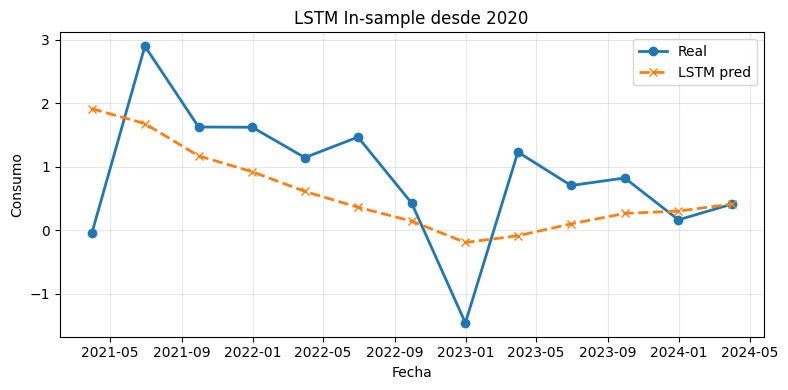


Config 2: RNN | ws=4, layers=2, units=128, dropout=0.3
     RMSE(2021-) = 3.4472, MAE(2021-) = 2.3374


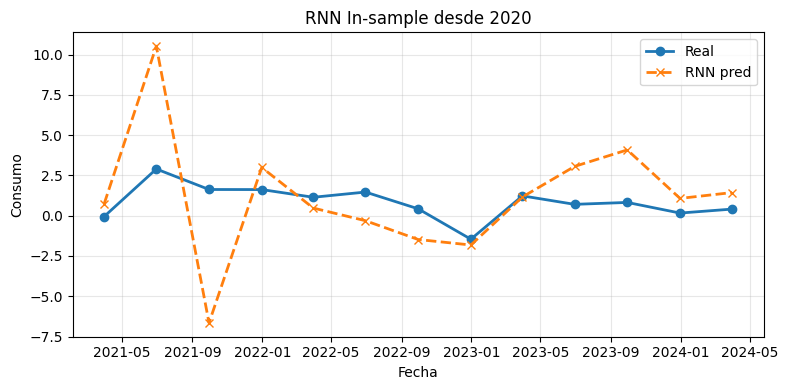


Config 3: LSTM | ws=12, layers=2, units=128, dropout=0.2
     RMSE(2021-) = 1.2342, MAE(2021-) = 1.0128


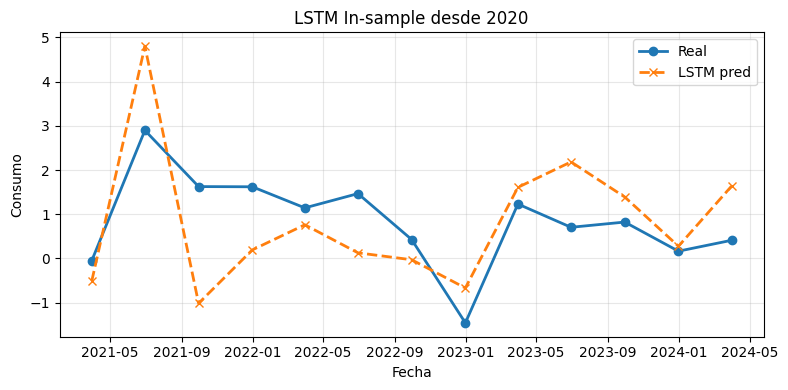


Config 4: RNN | ws=4, layers=1, units=128, dropout=0.0
     RMSE(2021-) = 3.6583, MAE(2021-) = 2.2011


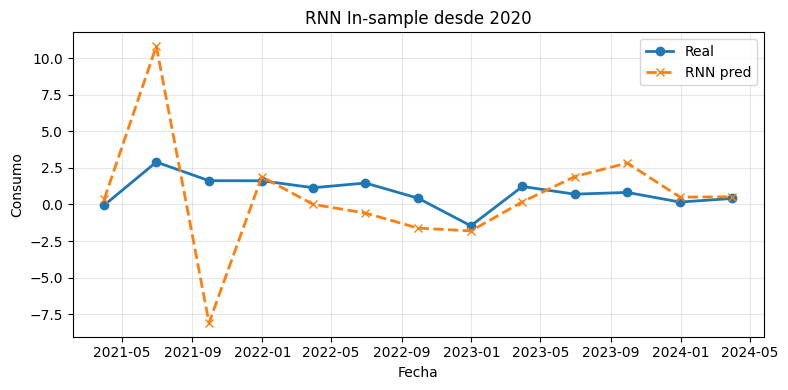


Config 5: GRU | ws=4, layers=3, units=128, dropout=0.1
     RMSE(2021-) = 0.9457, MAE(2021-) = 0.7370


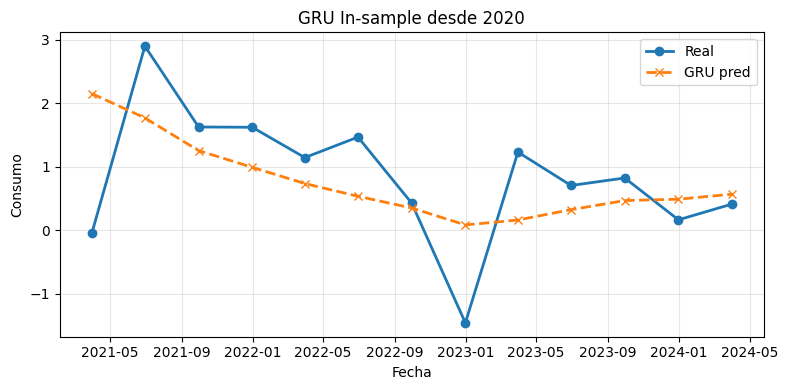

In [105]:
# Cell 14: In-sample backcasting para todas las Top-5 configuraciones

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# 1) Leer Top-5 configuraciones
top5 = pd.read_csv('results/top5_hyperparams.csv')

# 2) Definir las clases de modelo dinámicas
class RNNModel(nn.Module):
    def __init__(self, n_features, units, n_layers, dropout, bidirectional):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=n_features, hidden_size=units,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True
        )
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(units * direction, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        h = out[:, -1, :]
        return self.fc(h)

class LSTMModel(nn.Module):
    def __init__(self, n_features, units, n_layers, dropout, bidirectional):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features, hidden_size=units,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True
        )
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(units * direction, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        return self.fc(h)

class GRUModel(nn.Module):
    def __init__(self, n_features, units, n_layers, dropout, bidirectional):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_features, hidden_size=units,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True
        )
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(units * direction, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        h = out[:, -1, :]
        return self.fc(h)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3) Función helper para generar secuencias
def create_sequences_np(X_arr, y_arr, window):
    Xs, ys = [], []
    for i in range(window, len(X_arr)):
        Xs.append(X_arr[i-window:i])
        ys.append(y_arr[i])
    return np.array(Xs), np.array(ys)

# 4) Preparar datos completos escalados
X_full = df2[exog_vars].values
y_full = df2['Consumo'].values
X_full_scaled = scaler_X.transform(X_full)
y_full_scaled = scaler_y.transform(y_full.reshape(-1,1)).flatten()

# 5) Iterar sobre cada configuración y generar backcast
for idx, combo in top5.iterrows():
    mt      = combo.model_type
    nl      = int(combo.n_layers)
    units   = int(combo.units)
    dropout = float(combo.dropout)
    bi      = bool(combo.bidirectional)
    lr      = float(combo.lr)
    wd      = float(combo.kernel_regularizer)
    bs      = int(combo.batch_size)
    ep      = int(combo.epochs)
    ws      = int(combo.window_size)
    pat     = int(combo.patience)

    # 5.1) Crear secuencias in-sample
    X_seq, y_seq = create_sequences_np(X_full_scaled, y_full_scaled, ws)
    X_t = torch.tensor(X_seq, dtype=torch.float32, device=device)
    y_t = torch.tensor(y_seq, dtype=torch.float32, device=device).unsqueeze(-1)
    train_dl = DataLoader(TensorDataset(X_t, y_t), batch_size=bs, shuffle=False)

    # 5.2) Instanciar modelo según type
    n_feat = X_seq.shape[2]
    if mt == 'rnn':
        model = RNNModel(n_feat, units, nl, dropout, bi)
    elif mt == 'lstm':
        model = LSTMModel(n_feat, units, nl, dropout, bi)
    else:
        model = GRUModel(n_feat, units, nl, dropout, bi)
    model.to(device)

    # 5.3) Criterio y optimizador
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # 5.4) Entrenamiento con EarlyStopping
    best_loss, wait = np.inf, 0
    for epoch in range(ep):
        model.train()
        for xb, yb in train_dl:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            val_out = model(X_t)
            val_loss = criterion(val_out, y_t).item()
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= pat:
                break

    model.load_state_dict(best_state)
    model.eval()

    # 5.5) Predicción in-sample y desescalado
    with torch.no_grad():
        pred = model(X_t).cpu().numpy()
    true = y_t.cpu().numpy()
    pred_inv = scaler_y.inverse_transform(pred).flatten()
    true_inv = scaler_y.inverse_transform(true).flatten()

    # 5.6) Filtrar resultados desde 2020
    dates = df2.index[ws:]
    mask = dates >= '2021-01-01'
    dates_sel = dates[mask]
    true_sel = true_inv[mask]
    pred_sel = pred_inv[mask]

    # 5.7) Calcular métricas
    rmse = np.sqrt(mean_squared_error(true_sel, pred_sel))
    mae  = mean_absolute_error(true_sel, pred_sel)
    print(f"\nConfig {idx+1}: {mt.upper()} | ws={ws}, layers={nl}, units={units}, dropout={dropout}")
    print(f"     RMSE(2021-) = {rmse:.4f}, MAE(2021-) = {mae:.4f}")

    # 5.8) Visualización
    plt.figure(figsize=(8,4))
    plt.plot(dates_sel, true_sel, marker='o', label='Real', linewidth=2)
    plt.plot(dates_sel, pred_sel, '--', marker='x', label=f'{mt.upper()} pred', linewidth=2)
    plt.title(f"{mt.upper()} In-sample desde 2020")
    plt.xlabel('Fecha')
    plt.ylabel('Consumo')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


### 5.4 Visualización completa de la tercera combinación


Config 3: LSTM | ws=12, layers=2, units=128, dropout=0.2
     RMSE(2020-) = 1.2646, MAE(2020-) = 0.9032


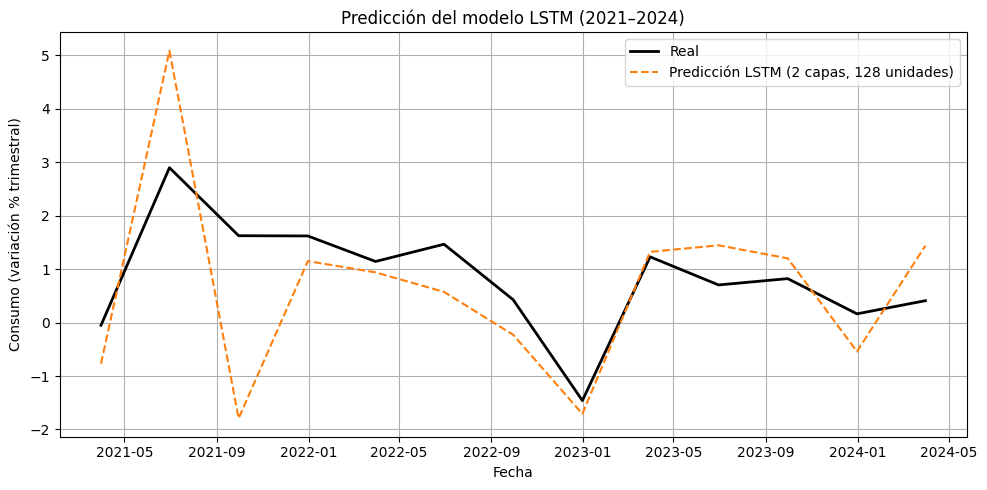

In [152]:
# Leer solo la tercera combinación (índice 2 porque Python indexa desde 0)
combo = pd.read_csv('results/top5_hyperparams.csv').iloc[2]

# Extraer los hiperparámetros de la combinación 3
mt      = combo.model_type
nl      = int(combo.n_layers)
units   = int(combo.units)
dropout = float(combo.dropout)
bi      = bool(combo.bidirectional)
lr      = float(combo.lr)
wd      = float(combo.kernel_regularizer)
bs      = int(combo.batch_size)
ep      = int(combo.epochs)
ws      = int(combo.window_size)
pat     = int(combo.patience)

# Crear secuencias in-sample
X_seq, y_seq = create_sequences_np(X_full_scaled, y_full_scaled, ws)
X_t = torch.tensor(X_seq, dtype=torch.float32, device=device)
y_t = torch.tensor(y_seq, dtype=torch.float32, device=device).unsqueeze(-1)
train_dl = DataLoader(TensorDataset(X_t, y_t), batch_size=bs, shuffle=False)

# Instanciar modelo según el tipo
n_feat = X_seq.shape[2]
if mt == 'rnn':
    model = RNNModel(n_feat, units, nl, dropout, bi)
elif mt == 'lstm':
    model = LSTMModel(n_feat, units, nl, dropout, bi)
else:
    model = GRUModel(n_feat, units, nl, dropout, bi)
model.to(device)

# Criterio y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Entrenamiento con EarlyStopping
best_loss, wait = np.inf, 0
for epoch in range(ep):
    model.train()
    for xb, yb in train_dl:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        val_out = model(X_t)
        val_loss = criterion(val_out, y_t).item()
    if val_loss < best_loss:
        best_loss = val_loss
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= pat:
            break

model.load_state_dict(best_state)
model.eval()

# Predicción in-sample y desescalado
with torch.no_grad():
    pred = model(X_t).cpu().numpy()
true = y_t.cpu().numpy()
pred_inv = scaler_y.inverse_transform(pred).flatten()
true_inv = scaler_y.inverse_transform(true).flatten()

# Filtrar resultados desde 2020
dates = df2.index[ws:]
mask = dates >= '2021-01-01'
dates_sel = dates[mask]
true_sel = true_inv[mask]
pred_sel = pred_inv[mask]

# Calcular métricas
rmse = np.sqrt(mean_squared_error(true_sel, pred_sel))
mae  = mean_absolute_error(true_sel, pred_sel)
print(f"\nConfig 3: {mt.upper()} | ws={ws}, layers={nl}, units={units}, dropout={dropout}")
print(f"     RMSE(2020-) = {rmse:.4f}, MAE(2020-) = {mae:.4f}")

# Visualización
plt.figure(figsize=(10, 5))

plt.plot(dates_sel, true_sel, label='Real', color='black', linewidth=2)
plt.plot(dates_sel, pred_sel, label='Predicción LSTM (2 capas, 128 unidades)', linestyle='--', color='tab:orange')

plt.title('Predicción del modelo LSTM (2021–2024)')
plt.xlabel('Fecha')
plt.ylabel('Consumo (variación % trimestral)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Resultados del modelo LSTM seleccionado (Configuración 3)

Tras evaluar múltiples configuraciones mediante validación cruzada y backtesting, se seleccionó como modelo final una red neuronal LSTM con las siguientes características:

- Arquitectura: **2 capas ocultas**
- Unidades por capa: **128**
- Función de activación: `tanh` (por defecto en LSTM)
- Dropout: **0.2**
- Ventana temporal: **12 trimestres**
- Optimizador: **Adam** con tasa de aprendizaje 0.0005
- Número de épocas: **200** con `early stopping` (paciencia = 20)

Este modelo fue entrenado sobre el conjunto completo de datos históricos (1995–2024) y validado sobre el período más reciente (2021–2024), utilizando una estrategia de predicción *one-step-ahead*.

El rendimiento obtenido fue:

- **RMSE (2021–2024)** = **1.2646**
- **MAE (2021–2024)** = **0.9032**



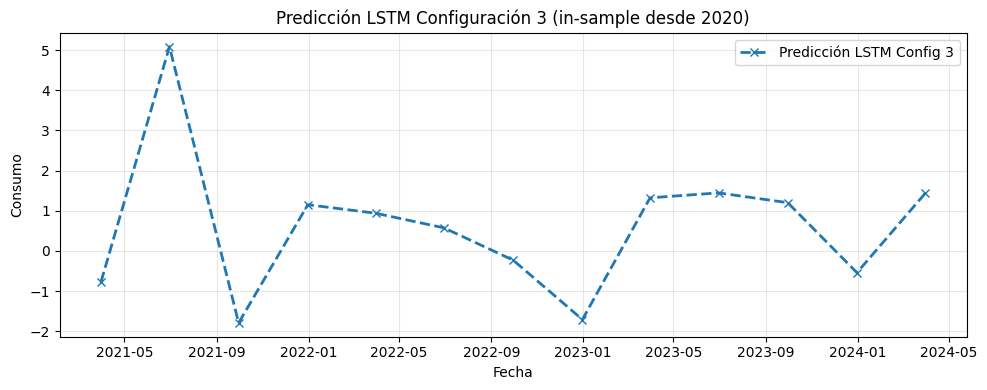

In [153]:
# Cell 15: Mostrar solo la predicción in-sample de la Configuración 3

import matplotlib.pyplot as plt


plt.figure(figsize=(10,4))
plt.plot(dates_sel, pred_sel, marker='x', linestyle='--', label='Predicción LSTM Config 3', linewidth=2)
plt.title('Predicción LSTM Configuración 3 (in-sample desde 2020)')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [154]:
from sklearn.metrics import mean_absolute_percentage_error

# suponiendo y_true_sel, y_pred_sel ya definidos para tu LSTM config 3:
mape   = mean_absolute_percentage_error(y_true_sel, y_pred_sel)
smape  = 100*np.mean( 2*np.abs(y_true_sel - y_pred_sel)/(np.abs(y_true_sel)+np.abs(y_pred_sel)) )
directional = np.mean(np.sign(np.diff(y_true_sel)) == np.sign(np.diff(y_pred_sel)))

print(f"MAPE: {mape:.2%}, SMAPE: {smape:.2f}%, Dir.Accuracy: {directional:.2%}")


MAPE: 296.62%, SMAPE: 87.04%, Dir.Accuracy: 68.75%


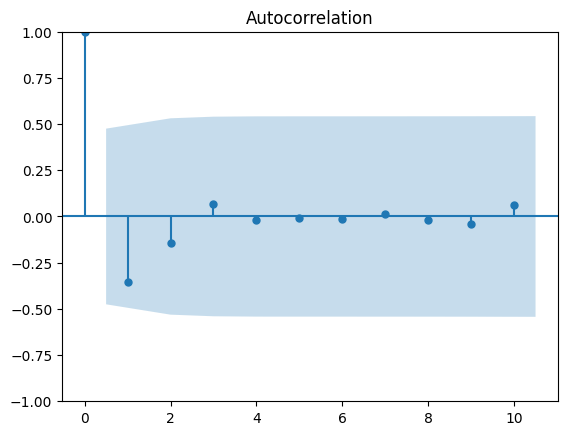

     lb_stat  lb_pvalue
10  3.337798   0.972321
ARCH LM stat=3.802, p=0.434


In [ ]:
import statsmodels.api as sm

resid = y_true_sel - y_pred_sel

# ACF de residuos
sm.graphics.tsa.plot_acf(resid, lags=10)
plt.show()

# Ljung-Box
lb = sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True)
print(lb)

# ARCH test
arch = sm.stats.het_arch(resid, nlags=4)
print(f"ARCH LM stat={arch[0]:.3f}, p={arch[1]:.3f}")


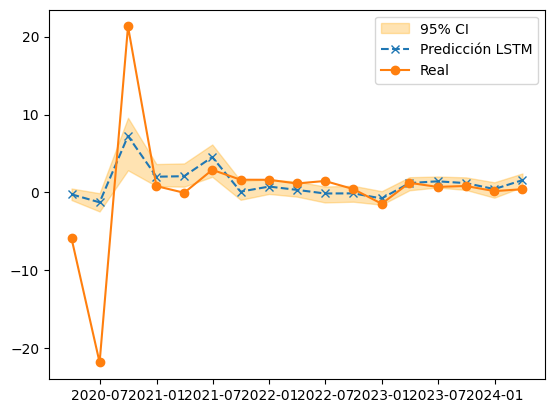

In [ ]:
# durante predict:
model.train()   # deja activo dropout
S = 100         # nº simulaciones
mc_preds = []
for _ in range(S):
    with torch.no_grad():
        p = model(X_t).cpu().numpy().flatten()
    mc_preds.append(scaler_y.inverse_transform(p.reshape(-1,1)).flatten())
mc_preds = np.array(mc_preds)    # shape (S, T)

lower = np.percentile(mc_preds, 2.5, axis=0)[mask]
upper = np.percentile(mc_preds, 97.5, axis=0)[mask]

# dibujar bandas
plt.fill_between(dates_sel, lower, upper, color='orange', alpha=0.3, label='95% CI')
plt.plot(dates_sel, pred_sel, 'x--', label='Predicción LSTM')
plt.plot(dates_sel, y_true_sel, 'o-', label='Real')
plt.legend(); plt.show()


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Params LSTM: {total_params}")


Params LSTM: 200833
